In [2]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad
from scipy.interpolate import interp1d
from scipy.special import erf
import matplotlib.pylab as pylab

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib as mpl

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from plot_params import params

pylab.rcParams.update(params)
# plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"

save_figs = False

alpha_plot = 1.
lw_plot = 2.5

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsha

In [4]:
# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

## Figure 4: differential power with mass and Galactocentric radius

In [118]:
# pspecpop = PowerSpectraPopulations(l_max=2000)

# pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-2*kpc, R_max=260*kpc)
# pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=0.05*1.1e12*M_s, 
#                                M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
# pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

In [121]:
# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

C_l_mu = pspecpop.get_C_l_total_ary();

  0%|          | 0/50 [00:00<?, ?it/s]

## Fig. 6: Fisher forecasts for discovery significance

In [122]:
# Test

sigma_mu = .1
sigma_alpha = None
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=10, l_max_mu=300, l_min_alpha=2, l_max_alpha=2000)

fshr = FisherForecast(parameters, observation)


lim = 1.64 * np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
print(lim)
baseline_sig = fDM_base/fshr.pars_vary[0].sigma
print(baseline_sig)

1.4240207218499032
1.151668634336672


### With tidal effects

In [80]:
sigma_mu_ary = np.logspace(-2,0,30)
N_q_ary = np.logspace(6,9,50)

In [81]:
sig_ary = np.zeros((len(sigma_mu_ary), len(N_q_ary)))
lim_ary = np.zeros((len(sigma_mu_ary), len(N_q_ary)))

for isigmu, sigmu in enumerate(tqdm_notebook(sigma_mu_ary)):
    for iNq, Nq in enumerate(N_q_ary):
        
        fDM_base = 1
        dfDM_base = 0.1

        Cl_ary_fid = C_l_mu*fDM_base

        p = C_l_mu*(fDM_base + dfDM_base)
        m = C_l_mu*(fDM_base - dfDM_base)

        fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                        None, None, '$\\f_\mathrm{DM}$' )

        parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigmu, sigma_alpha=None, N_q_mu=Nq, l_min_mu=10, l_max_mu=500, l_min_alpha=2, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)
        lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
        sig_ary[isigmu, iNq] = fDM_base/fshr.pars_vary[0].sigma
        lim_ary[isigmu, iNq] = lim


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


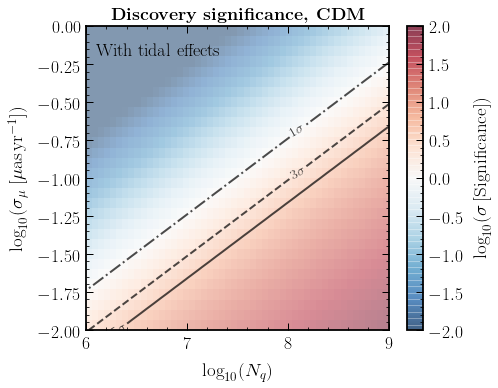

In [83]:
mpl.rcParams['figure.figsize'] = 7, 5.5

levels = [np.log10(1),np.log10(3),np.log10(5)]
X, Y = np.meshgrid(np.log10(N_q_ary), np.log10(sigma_mu_ary))

fig, ax = plt.subplots()

CS = ax.contour(X, Y, np.log10(sig_ary), levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# im = ax.imshow(np.log10(sig_ary), cmap = palettable.cmocean.sequential.Ice_20_r.get_mpl_colormap(), aspect='auto', origin='lower', extent=[6,9,-2,0], vmin=np.log10(1), vmax=np.log10(1e3))
im = ax.imshow(np.log10(sig_ary), alpha=0.5, cmap='RdBu_r', aspect='auto', origin='lower', extent=[6,9,-2,0], vmin=np.log10(0.01), vmax=np.log10(1e2))

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(N_q)$")
ax.set_ylabel("$\log_{10}(\sigma_\mu~[\mu$as\,yr$^{-1}$])")
ax.set_title('\\textbf{Discovery significance, CDM}', fontsize=18)

ax.text(6.1, -.2, "With tidal effects", fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('$\log_{10}(\sigma$\,[Significance])')

plt.tight_layout()
plt.savefig(plots_dir + "LCDM_disc.pdf")

### No tidal effects

In [15]:
sig_ary_notidal = np.zeros((len(sigma_mu_ary), len(N_q_ary)))
lim_ary_notidal = np.zeros((len(sigma_mu_ary), len(N_q_ary)))

for isigmu, sigmu in enumerate(tqdm_notebook(sigma_mu_ary)):
    for iNq, Nq in enumerate(N_q_ary):
        
        fDM_base = 1
        dfDM_base = 0.1

        Cl_ary_fid = C_l_mu*fDM_base

        p = C_l_mu_notidal*(fDM_base + dfDM_base)
        m = C_l_mu_notidal*(fDM_base - dfDM_base)

        fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                        None, None, '$\\f_\mathrm{DM}$' )

        parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigmu, sigma_alpha=None, N_q_mu=Nq, l_min_mu=10, l_max_mu=500, l_min_alpha=2, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)
        lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
        sig_ary_notidal[isigmu, iNq] = fDM_base/fshr.pars_vary[0].sigma
        lim_ary_notidal[isigmu, iNq] = lim


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


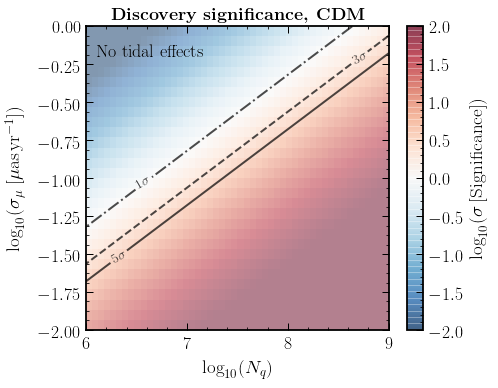

In [16]:
mpl.rcParams['figure.figsize'] = 7, 5.5

levels = [np.log10(1),np.log10(3),np.log10(5)]
levels_lim = [1.]

X, Y = np.meshgrid(np.log10(N_q_ary), np.log10(sigma_mu_ary))

fig, ax = plt.subplots()

CS = ax.contour(X, Y, np.log10(sig_ary_notidal), levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)
# CS_lim = ax.contour(X, Y, lim_ary_notidal, levels = levels_lim, linestyles=['-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
fmt_lim = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
strs_lim = ['$95\%$ limit']

for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# for l, s in zip(CS_lim.levels, strs_lim):
#     fmt_lim[l] = s

# im = ax.imshow(np.log10(sig_ary_notidal), cmap = palettable.cmocean.sequential.Ice_20_r.get_mpl_colormap(), aspect='auto', origin='lower', extent=[6,9,-2,0], vmin=np.log10(1), vmax=np.log10(1e3))
im = ax.imshow(np.log10(sig_ary_notidal), cmap='RdBu_r', alpha=0.5, aspect='auto', origin='lower', extent=[6,9,-2,0], vmin=np.log10(0.01), vmax=np.log10(1e2))

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)
# ax.clabel(CS_lim,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(N_q)$")
ax.set_ylabel("$\log_{10}(\sigma_\mu~[\mu$as\,yr$^{-1}$])")
ax.set_title('\\textbf{Discovery significance, CDM}', fontsize=18)

ax.text(6.1, -0.2, "No tidal effects", fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('$\log_{10}(\sigma$\,[Significance])')

plt.tight_layout()
plt.savefig(plots_dir + "LCDM_disc_notidal.pdf")
